In [12]:
import numpy
import matplotlib.pyplot
import os
import json
#for partial specialization
import cModel
import importlib
importlib.reload(cModel)
import time
import ivp
importlib.reload(ivp)
import runSolver
importlib.reload(runSolver)
import numpy.linalg

def getModel(solution,modelName):
    Q=solution[modelName]
    model=cModel.model()
    setupFile=Q['setup']
    modelFile=Q['model']
    parameterFile=Q['parameters']
    print('modelFile: {} {}'.format(modelFile,os.path.isfile(modelFile)))
    print('parameterFile: {} {}'.format(parameterFile,os.path.isfile(parameterFile)))
    model.parse(modelFile,parameterFile)
    return model

def getSum(data,modelName):
    
    model=getModel(data,modelName)
    Q=data[modelName]['solution']
    lut=Q['lut']
    total=Q['sol'][-1,lut['total']]
    #print(total)
    fQ={}
    for x in lut:
        if x=='total':
            continue
        j=lut[x]
        try:
            v=model.get(model.mod['volumes'][x])['value']
            fQ[x]=Q['sol'][-1,j]*v/total
        except KeyError:
            #print('{} {}'.format(x,x in model.mod['scaled']))
            fQ[x]=Q['sol'][-1,j]
    print(sum(list(fQ.values())))
    print(sorted(fQ.items(), key=lambda item:item[1]))

def mergeSolutions(seq):
    out={}
    #each element in sequence should have this components
    for v in ['t','sol','se','qt','sOut']:
        out[v]=numpy.concatenate([x[v] for x in seq])
    #copy last for settings
    for v in ['lut','lutSE','setup','model','parameters','qt','sOut']:
        out[v]=seq[-1][v]
    return out 

def updateSetup(job):
    setupFileSrc=job['setupFile']
    setupFile=os.path.join(job['jobDir'],'setupInput.json')

    with open(setupFileSrc,'r') as f:
        setup=json.load(f)
    try:
        setup.update(job['setupUpdates'])
    except KeyError:
        pass
    
    with open(setupFile,'w+') as f:
        f.write(json.dumps(setup))
    return setupFile
        

In [ ]:
a={}
fh=os.path.expanduser('~')
a['jobDir']=os.path.join(fh,'temp','cDiazepam')
a['modelFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam.json')
a['parameterFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam_parameters.json')
a['setupFile']=os.path.join(fh,'software','src','PBPK','setup','setupMinute.json')
model=cModel.model()
model.parse(a['modelFile'],a['parameterFile'])
model.inspect()
model.get('venousInput')
#runSolver.main([a['setupFile'],a['modelFile'],a['parameterFile']],jobDir=a['jobDir'],startDir='NONE')

In [32]:
#run solver
fh=os.path.expanduser('~')
i=0
data={}
a={}
#based on
#MD Thompson, DA Beard, F Wu. Use of partition coefficient in flow-limited physiologically based pharmacokinetic modelling. 
#J Pharmacokinet Pharmacodyn 39 (4) 2012.
a['jobDir']=os.path.join(fh,'temp','cDiazepam')
a['modelFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam.json')
#set input to 1 for one minute
a['parameterFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam_parameters1.json')
a['setupFile']=os.path.join(fh,'software','src','PBPK','setup','setupMinute.json')
a['srcDir']='NONE'
a['doCalculate']=True
data['cDiazepam']=[a]

c={}
c['jobDir']=os.path.join(fh,'temp','cDiazepam1')
c['modelFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam.json')
#set input to 0
c['parameterFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam_parameters2.json')
c['setupFile']=os.path.join(fh,'software','src','PBPK','setup','setupHours.json')
c['srcDir']=os.path.join(fh,'temp','cDiazepam')
c['doCalculate']=True
#data['cDiazepam'].append(c)

b={}
#MD Thompson, DA Beard, F Wu. Use of partition coefficient in flow-limited physiologically based pharmacokinetic modelling. 
#J Pharmacokinet Pharmacodyn 39 (4) 2012.
b['jobDir']=os.path.join(fh,'temp','cDiazepamF')
b['modelFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam.json')
b['parameterFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam_parameters.json')
b['setupFile']=os.path.join(fh,'software','src','PBPK','setup','setupMinute.json')
b['srcDir']='NONE'
b['doCalculate']=True
data['cDiazepamF']=[b]

d={}
#MD Thompson, DA Beard, F Wu. Use of partition coefficient in flow-limited physiologically based pharmacokinetic modelling. 
#J Pharmacokinet Pharmacodyn 39 (4) 2012.
d['jobDir']=os.path.join(fh,'temp','cDiazepamB')
d['modelFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam.json')
d['parameterFile']=os.path.join(fh,'software','src','PBPK','models','cDiazepam_parameters3.json')
d['setupFile']=os.path.join(fh,'software','src','PBPK','setup','setupHours.json')
#d['setupUpdates']={'mode':'solveMatrix','method':'separately'}
d['srcDir']='NONE'
d['doCalculate']=True
#data['cDiazepamB']=[d]

#make sure we do it in proper order
for x in data:
    seq=data[x]
    for job in seq:
        if not job['doCalculate']:
            continue
    
        if not os.path.isdir(job['jobDir']):
            os.mkdir(job['jobDir'])
            
        #adjust local setup file with ad-hoc modifications
        setupFile=updateSetup(job)
        
        runSolver.main([setupFile,job['modelFile'],job['parameterFile']],job['jobDir'],job['srcDir'])
    

#t0,y0,S1,lut,lutSE=runSolver.getStartPoint(setup)


Using /home/studen/temp/cDiazepam
Using solution from None
t0=0
t0 0 tmax 1.0
At t=21.86
At t=33.23
At t=44.66
At t=59.22
At t=75.71
At t=93.42
Done simultaneous LSODA SE
Time: 0.479 s
Completed step _step000
Completed run
Written /home/studen/temp/cDiazepam/setup.json
Written /home/studen/temp/cDiazepam/model.json
Written /home/studen/temp/cDiazepam/parameters.json
Using /home/studen/temp/cDiazepamF
Using solution from None
t0=0
t0 0 tmax 1.0
At t=24.99
At t=33.75
At t=38.07
At t=42.68
At t=45.68
At t=48.08
At t=50.55
At t=53.08
At t=55.98
At t=59.13
At t=62.36
At t=65.66
At t=69.04
At t=72.48
At t=75.95
At t=79.27
At t=82.21
At t=85.19
At t=88.22
At t=91.32
At t=94.46
At t=97.66
Done simultaneous LSODA SE
Time: 7.988 s
Completed step _step000
Completed run
Written /home/studen/temp/cDiazepamF/setup.json
Written /home/studen/temp/cDiazepamF/model.json
Written /home/studen/temp/cDiazepamF/parameters.json


In [33]:
#make solutions transparent
solution={}
for x in data:
    seq=[runSolver.loadSolutionFromDir(job['jobDir'],True) for job in data[x]]
    solution[x]=mergeSolutions(seq)


t0 0 tmax 1.0
Parsing [1/1]
t0 0 tmax 1.0
Parsing [1/1]


modelFile: /home/studen/temp/cDiazepamF/model.json True
parameterFile: /home/studen/temp/cDiazepamF/parameters.json True
tscale=1
Time unit: min
Compartments
adipose/0:
	targets
		adipose[0,0]: [-0.01103896103896104]
		arterial[0,13]: [0.255]
brain/1:
	targets
		brain[1,1]: [-0.2954545454545454]
		arterial[1,13]: [0.65]
heart/2:
	targets
		heart[2,2]: [-0.9767441860465117]
		arterial[2,13]: [4.2]
kidney/3:
	targets
		kidney[3,3]: [-1.5971153846153845]
		arterial[3,13]: [8.305]
liver/4:
	targets
		liver[4,4]: [-0.057272727272727274, -0.25674325674325676]
		splanchnic[4,5]: [0.4281183932346723]
		stomach[4,6]: [0.03838383838383838]
		arterial[4,13]: [0.3227272727272727]
splanchnic/5:
	targets
		splanchnic[5,5]: [-0.3139534883720931]
		arterial[5,13]: [1.35]
stomach/6:
	targets
		stomach[6,6]: [-0.3838383838383838]
		arterial[6,13]: [1.727272727272727]
muscle/7:
	targets
		muscle[7,7]: [-0.05416666666666667]
		arterial[7,13]: [0.13]
skin/8:
	targets
		skin[8,8]: [-0.05065639269406392]
		a

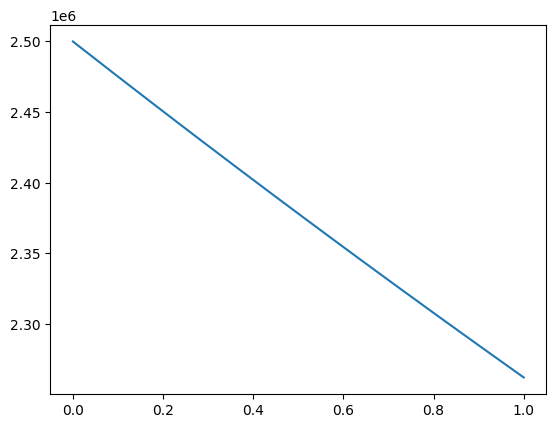

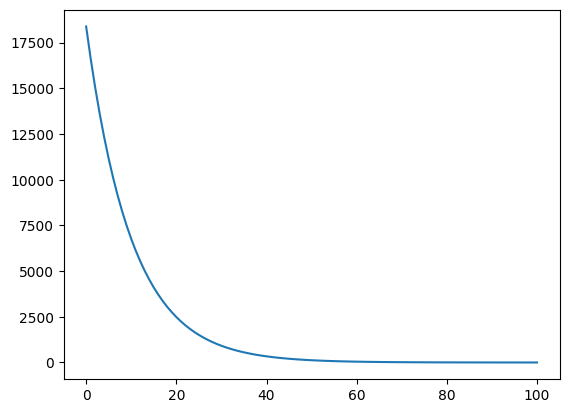

In [27]:
modelName='cDiazepamF'
model=getModel(solution,modelName)
setup=solution[modelName]['setup']
tscale=runSolver.getScale(solution[modelName]['setup'])
print(f'tscale={tscale}')
model.inspect()    

print("***********done************")
print(model.M(1).shape)
#print(sys.fSS(2))
print(model.m)

nt=setup['nt']
qtmax=1 #minute
qt=numpy.linspace(0,qtmax,nt)
#ft=[fw['derivatives']['fetusGrowthDuration'](x) for x in qt]
par='venousInput'
#plot parameters
try:
    hw=model.get(par)
    print(hw)
    ht=[10*hw['value'](x) for x in qt]
    matplotlib.pyplot.plot(qt/tscale,ht)
except (KeyError,TypeError):
    print(f'Troubles getting {par}')
    pass
start_time=time.time()
for i in range(100000):
    model.M(1e7)
end_time=time.time()
print('Time: {:.3f} s'.format(end_time-start_time))
fM=model.M(0)
print('Rank: {}/{}'.format(numpy.linalg.matrix_rank(fM),fM.shape))
numpy.set_printoptions(suppress=True,precision=2,linewidth=150)
print(f'{fM}')
v,Q=numpy.linalg.eig(fM)
#matplotlib.pyplot.imshow(Q.real)
numpy.set_printoptions(suppress=False)
print(Q[:,2:4])
Q1=numpy.linalg.inv(Q)
D=numpy.diag(v)
#nearly 0
#print(Q @ D @ Q1 - fM)
t=numpy.linspace(0,100,101)
fy=[model.u(x)[14] for x in t]
print('{} {}'.format(len(fy),len(t)))
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(fy)
fu=model.u(0)
print(Q1 @ fu)

modelFile: /home/studen/temp/cDiazepam/model.json True
parameterFile: /home/studen/temp/cDiazepam/parameters.json True


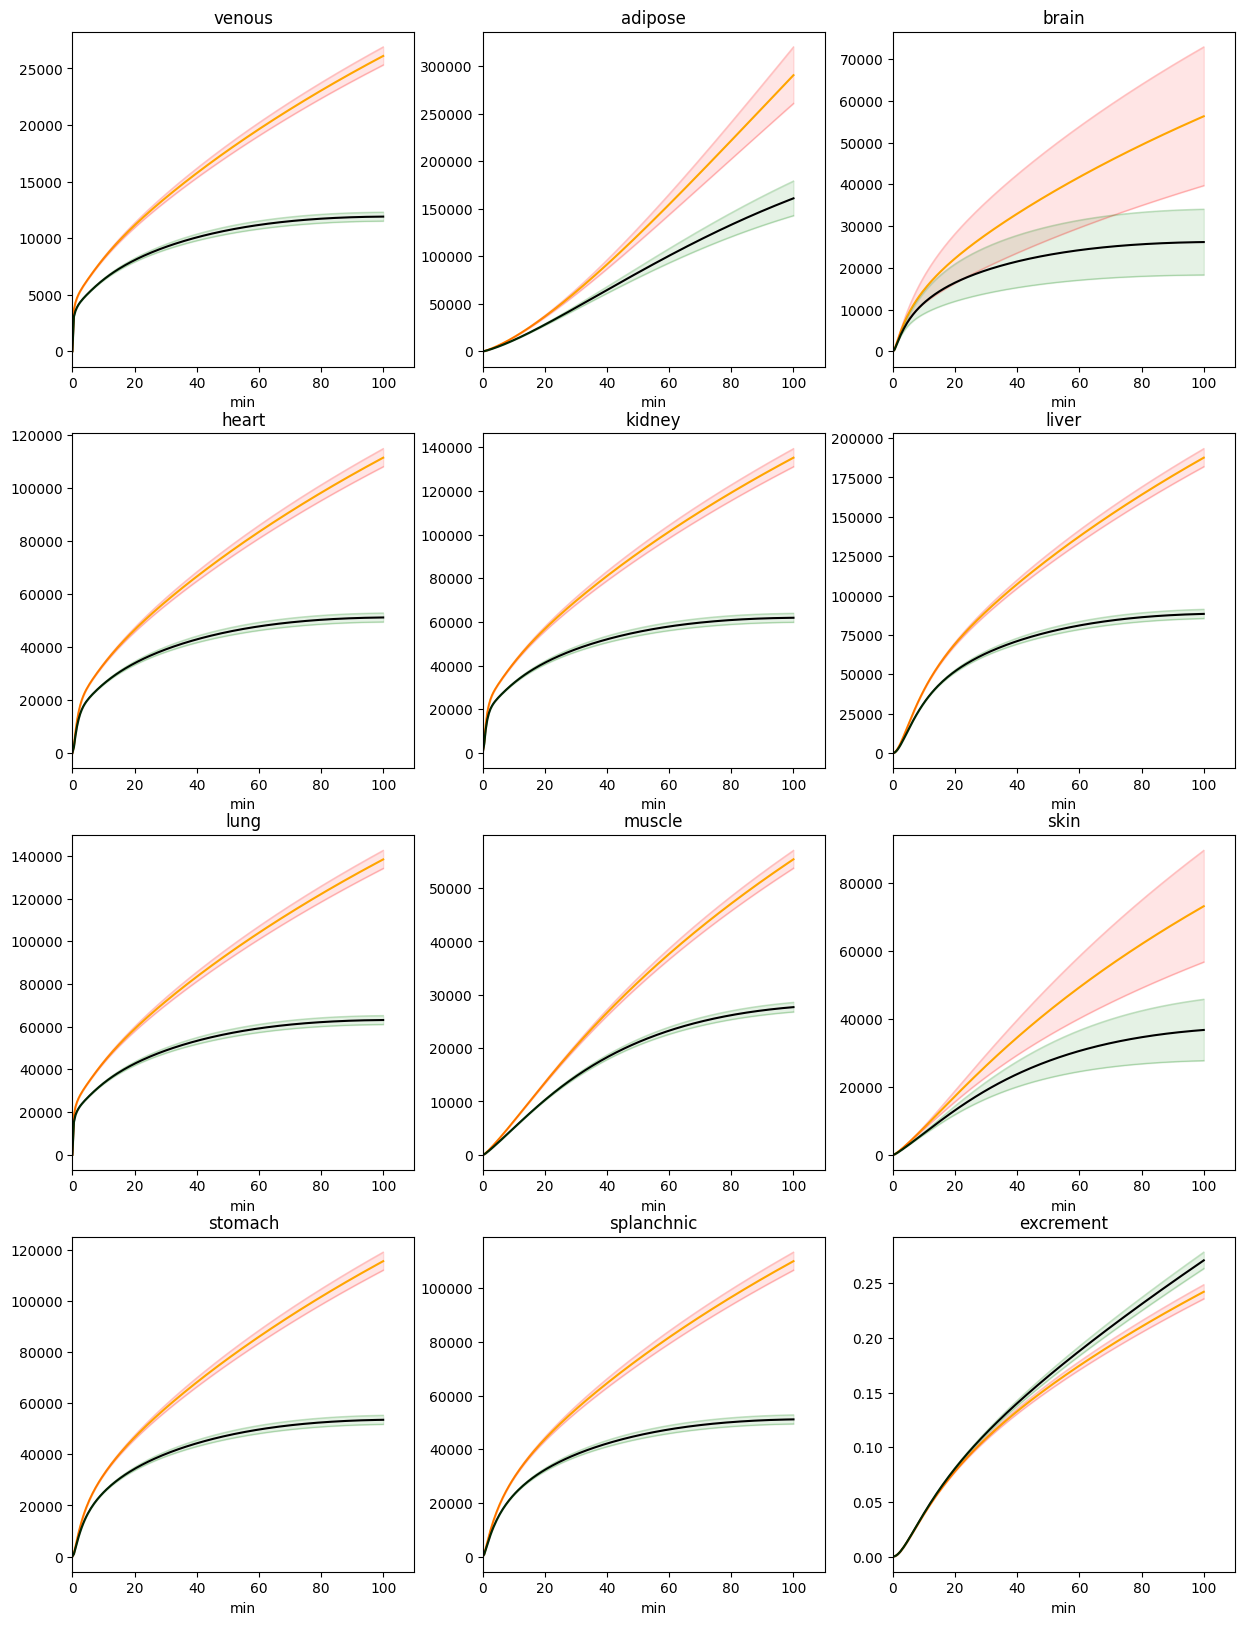

In [34]:
i=0
modelName='cDiazepam'
model=getModel(solution,modelName)
tscale=runSolver.getScale(solution[modelName]['setup'])
setup=solution[modelName]['setup']
name=['venous','adipose','brain',
      'heart','kidney','liver',
      'lung','muscle','skin',
      #'brainBlood','inorganicMercury','total'
     'stomach','splanchnic','excrement'
      ]
tmax=solution[modelName]['t'][-1]
max=[-1]*len(name)
#max[2]=2000
models={}
models['cDiazepam']={'color':'orange','shadeColor':'red'}
models['cDiazepamF']={'color':'black','shadeColor':'green'}
#models['cDiazepamB']={'color':'blue','shadeColor':'orange'}

fig, axs = matplotlib.pyplot.subplots(4, 3,figsize=(15,20))
for i in range(len(name)):
    row=i//3
    col=i%3
    ax=axs[row,col]
    for m in models:
        fM=models[m]
        Q=solution[m]
        v=name[i]
        try:
            j=Q['lut'][v]
        except KeyError:
            try:
                v1=alias[v]
            except KeyError:
                print('No data for {}'.format(v))
                continue    
            try:
                j=Q['lut'][v1]
            except KeyError:
                print('No data for {}/{}'.format(v,v1))
                continue    
                
        fy=Q['sol'][:,j]
        fe=Q['se'][:,j]
        t=Q['t']
        ax.plot(t/tscale,fy,color=fM['color'])
        ax.fill_between(t/tscale, fy-fe, fy + fe, color=fM['shadeColor'],alpha=0.1)
        ax.plot(t/tscale,fy-fe,color=fM['shadeColor'],linewidth=1,alpha=0.2)
        ax.plot(t/tscale,fy+fe,color=fM['shadeColor'],linewidth=1,alpha=0.2)
        
        
    if max[i]>0:
        axs[row,col].set_ylim([0,max[i]])
    axs[row,col].set_xlim([0,1.1*tmax/tscale])
    axs[row,col].set_xlabel(setup['tUnit'])
    axs[row,col].set_title(name[i])
    



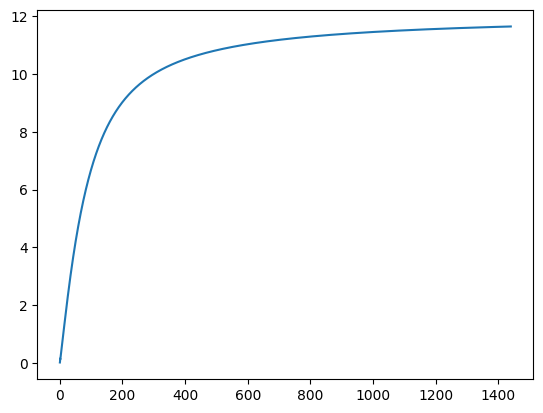

In [59]:
Q=data['humanHG_RBC']['solution']
lut=Q['lut']
fy1=Q['sol'][:,lut['redBloodCells']]
fy=Q['sol'][:,lut['plasma']]
qy=fy1[1:]/fy[1:]
t=Q['t']
matplotlib.pyplot.plot(t[1:],qy)

In [ ]:

pmodel=cModel.model()

model.parse(modelFile,parameterFile)
print('w(oI) {}'.format(model.getWeight('oralIngestion')))
t,sol,se,sOut,qt,lut,lutSE,setup1=runSolver.loadSolutionFromDir(humanHG)
compartment='kidney'
#compartment='liverI'
d=model.getDerivatives(sOut,lut[compartment])
w=model.getWeights(lutSE)
w=numpy.ones((len(lutSE)))
print('Sum ({}, der, sigma_p)'.format(compartment))
s={x:d[lutSE[x]]*w[lutSE[x]] for x in lutSE}
s=dict(sorted(s.items(), key=lambda item:item[1],reverse=True))
for p in list(s)[:10]:
    j=lutSE[p]
    print('\t{:.2g} [{:.2g} {:.2g}] {} '.format(d[j]*w[j],d[j],w[j],p))

In [23]:
model=getModel(data,'humanHGplusI_RBC')
tscale=runSolver.getScale(data['humanHGplusI_RBC']['solution']['setup'])
#calculate total mass of xeno-substance
model.get("bloodToPlasmaPCscale")
model.get("bloodVolume")


modelFile: /home/studen/temp/humanHGplusI_RBC/model.json True
parameterFile: /home/studen/temp/humanHGplusI_RBC/parameters.json True


{'value': 4.33728,
 'derivatives': {'plasmaTotalVolumeFraction': 67.77,
  'redBloodCellsVolumeFraction': 67.77,
  'bodyWeight': 0.064}}

In [40]:
getSum(data,'humanHGplusI_RBC')
tscale=runSolver.getScale(Q['setup'])
#calculate total mass of xeno-substance
model.get("bloodToPlasmaPCscale")
model.get("bloodVolume")

modelFile: /home/studen/temp/humanHGplusI_RBC/model.json True
parameterFile: /home/studen/temp/humanHGplusI_RBC/parameters.json True
0
1
2
3
5
6
7
9
10
11
12
13
15
16
17
19
0.999999998652029
[('brainI', 5.591268564730524e-08), ('urine', 6.920503851883565e-07), ('hairI', 2.829112820729282e-06), ('hair', 2.5908112965118847e-05), ('bloodI', 6.48014370354082e-05), ('kidneyI', 0.00034539782696188444), ('brainBlood', 0.0008838108138251085), ('fecesI', 0.0009365878956040508), ('liverI', 0.0016857155746677485), ('plasma', 0.002537491433132075), ('venous', 0.0025444401202051573), ('brain', 0.004082574560654416), ('kidney', 0.010365728769627663), ('gut', 0.013662463918991298), ('fat', 0.0257916393847429), ('feces', 0.02667203433643526), ('redBloodCells', 0.03545009717387017), ('richlyPerfused', 0.0636064259191453), ('liver', 0.09840624607901789), ('intestine', 0.30824288460368277), ('slowlyPerfused', 0.40469217361557336)]


{'value': 4.33728,
 'derivatives': {'plasmaTotalVolumeFraction': 67.77,
  'redBloodCellsVolumeFraction': 67.77,
  'bodyWeight': 0.064}}